In [1]:
import common.time_layers as TL
import pickle
import numpy as np


class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, H, D = vocab_size, wordvec_size, hidden_size
        # rn = np.random.randn
        # embed_W = (rn(V, D) / 100).astype('f')
        # lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        # lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        # lstm_b = np.zeros(4 * H).astype('f')
        # affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        # affine_b = np.zeros(V).astype('f')
        normal = np.random.normal
        mu = 0
        root = np.sqrt
        embed_W = normal(mu, 0.01, (V, D))
        lstm_Wx = normal(mu, 1/root(D), (D, 4*H))
        lstm_Wh = normal(mu, 1/root(H), (H, 4*H))
        lstm_b = np.zeros(4*H, dtype=np.float_)
        affine_W = normal(mu, 1/root(H), (H, V))
        affine_b = np.zeros(V, dtype=np.float_)

        self.layers = (
            TL.TimeEmbedding(embed_W),
            TL.TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TL.TimeAffine(affine_W, affine_b)
        )
        self.loss_layer = TL.TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params.extend(layer.params)
            self.grads.extend(layer.grads)

    def predict(self, xs: np.ndarray):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, fname="Rnnlm.pkl"):
        with open(fname, "wb")as f:
            pickle.dump(self.params, f)

    def load_params(self, fname="Rnnlm.pkl"):
        with open(fname, "rb") as f:
            self.params = pickle.load(f)


| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.57
| epoch 1 |  iter 21 / 1327 | time 14[s] | perplexity 2631.33
| epoch 1 |  iter 41 / 1327 | time 28[s] | perplexity 1216.30
| epoch 1 |  iter 61 / 1327 | time 41[s] | perplexity 968.05
| epoch 1 |  iter 81 / 1327 | time 53[s] | perplexity 770.08
| epoch 1 |  iter 101 / 1327 | time 68[s] | perplexity 643.45
| epoch 1 |  iter 121 / 1327 | time 80[s] | perplexity 640.85
| epoch 1 |  iter 141 / 1327 | time 95[s] | perplexity 590.62
| epoch 1 |  iter 161 / 1327 | time 108[s] | perplexity 568.16
| epoch 1 |  iter 181 / 1327 | time 123[s] | perplexity 561.76
| epoch 1 |  iter 201 / 1327 | time 136[s] | perplexity 492.77
| epoch 1 |  iter 221 / 1327 | time 149[s] | perplexity 482.28
| epoch 1 |  iter 241 / 1327 | time 160[s] | perplexity 446.70
| epoch 1 |  iter 261 / 1327 | time 172[s] | perplexity 452.61
| epoch 1 |  iter 281 / 1327 | time 186[s] | perplexity 458.82
| epoch 1 |  iter 301 / 1327 | time 198[s] | perplexity 389.39
| ep

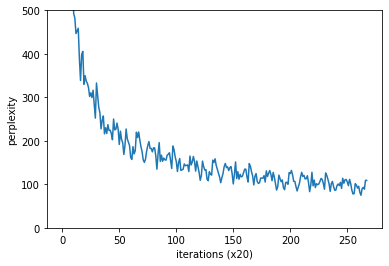

AttributeError: 'Rnnlm' object has no attribute 'reset_state'

In [ ]:
# coding: utf-8
from common.optimizers import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))



In [3]:
# テストデータで評価
model.rest_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

evaluating perplexity ...
234 / 235
test perplexity:  134.51278397479436
